Uploading experimental ISM dataset composed of tubulin HeLa cell from server and plotting

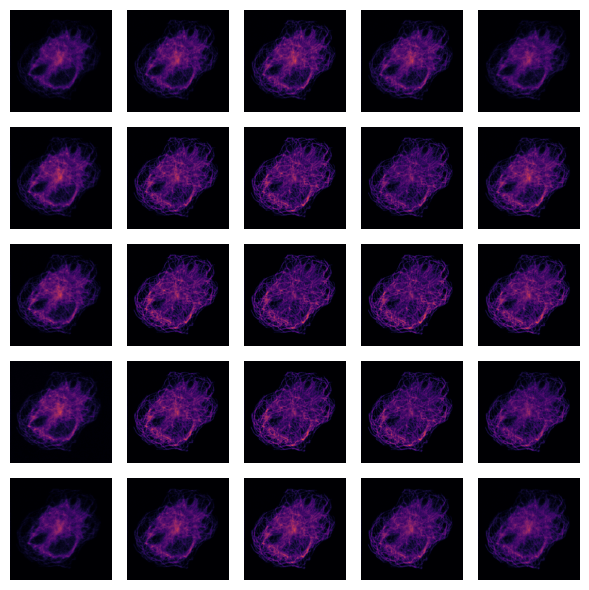

In [19]:
import numpy as np
import brighteyes_ism.analysis.Tools_lib as tool
import brighteyes_ism.dataio.mcs as mcs
import os

path = r'C:\Users\ggarre\Fondazione Istituto Italiano Tecnologia\Molecular Microscopy and Spectroscopy - 27_Maximum_Likelihood_Axial_Reconstruction\01_Data\Cell\A'
file = 'data-16-12-2022-18-20-18.h5'

fullpath = os.path.join(path, file)

data, meta = mcs.load(fullpath)

data = np.squeeze(data)
dset = np.sum(data, axis = -2)

fig = tool.ShowDataset(dset, cmap='inferno')

In [21]:
meta.Print()

version       0.0.1
comment       
rangex        35.0
rangey        35.0
rangez        0.0
nbin          50
dt            1.0
nx            875
ny            875
nz            1
nrep          1
calib_x       17.303
calib_y       17.409
calib_z       10.0


calculating shift vector of the ISM dataset to simulate PSFs properly and plotting shift vectors

C:\Users\ggarre\AppData\Local\anaconda3\envs\AMD\lib\site-packages\brighteyes_ism\analysis\Tools_lib.py:477: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(shift[:, 0], shift[:, 1], s=80, c=color, edgecolors='black', cmap=cmap)


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Shift vectors'}, xlabel='Shift$_x$ (nm)', ylabel='Shift$_y$ (nm)'>)

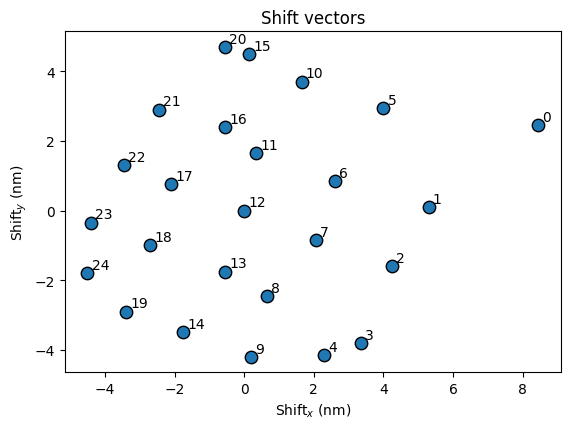

In [22]:
from brighteyes_ism.analysis import APR_lib as apr

upsampling_factor = 20
Nch = dset.shape[-1]
ref = Nch // 2
N = int(np.sqrt(Nch))
shift_cell = apr.APR (cell, upsampling_factor, ref  )[0]

tool.PlotShiftVectors(shift_cell)


Galvanometric mirrors lead a rotation effect on the acquired ISM dataset.
Given that we perform deconvolution with simulated PSFs we need to have the most reliable simulation possible, and so take into account this rotation effect.
Here the step by step process of the fitting.



We perform the fitting of the simulated shifts on the experimental shifts only considering the central 3x3 ring of shifts, that is usually the most regular in shape.
We simulate a 3x3 set of shift vectors with unitary pixel distance

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Shift vectors'}, xlabel='Shift$_x$ (nm)', ylabel='Shift$_y$ (nm)'>)

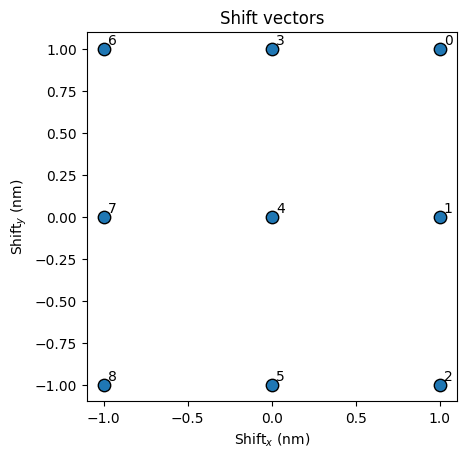

In [23]:
import ShiftVectorMinimizer as svm

shift_sim = svm.ShiftMatrix()

tool.PlotShiftVectors(shift_sim)

We crop the 5x5 experimental shift vectors into the 3x3 central ring of shift

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Shift vectors'}, xlabel='Shift$_x$ (nm)', ylabel='Shift$_y$ (nm)'>)

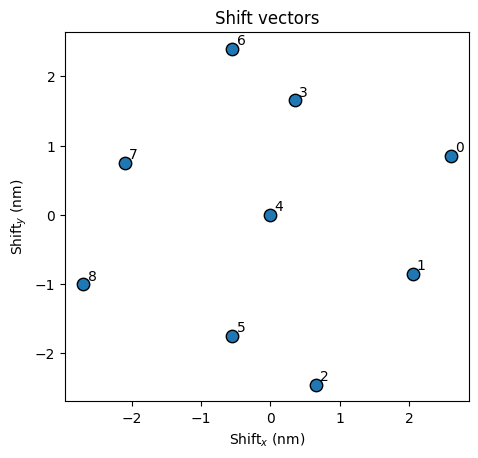

In [24]:
shift_cell_crop = svm.CropShift(shift_cell)

tool.PlotShiftVectors(shift_cell_crop)

Now we perform the fitting of the simulated shifts on the experimental shifts on rotation angle, dilatation factor and mirroring parameter.
We de facto minimize the following problem
$$
\begin{equation}
    \hat{\theta} , \hat{\alpha}, \hat{\beta}=\arg \min_{\alpha ,\theta,\beta} \sum_{x_d} | \boldsymbol\mu_{exp}(\bold{x_d})-\bold{A}(\alpha)\bold{R}(\theta)\bold{M}(\beta)\boldsymbol\mu_{th}(\bold{x_d}) |^2
\end{equation} $$

where $ \boldsymbol\mu_{exp}(\bold{x_d})$ are the experimental cropped shifts and $\boldsymbol\mu_{th}(\bold{x_d})$ the simulated ones.
$\hat{\theta} , \hat{\alpha}, \hat{\beta}$ are respectively the optimal rotation parameter, dilatation parameter and mirroring parameter.

We find those parameters as follows

In [25]:
parameters = svm.FindParam(shift_cell)



We apply the retrieved parameters to the simulated shifts

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Shift vectors'}, xlabel='Shift$_x$ (nm)', ylabel='Shift$_y$ (nm)'>)

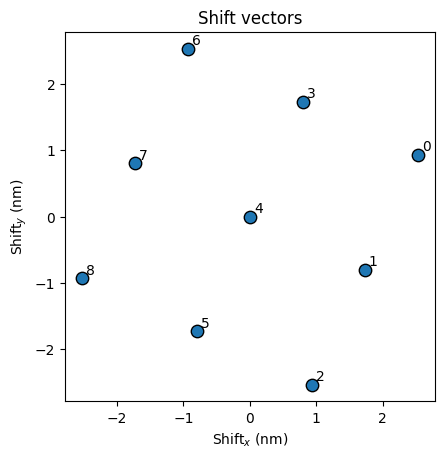

In [26]:
shift_sim_rot = svm.TransformShiftVectors(parameters, shift_sim)

tool.PlotShiftVectors(shift_sim_rot)

We perform comparison between fitted simulated shifts and experimental ones

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Shift vectors'}, xlabel='Shift$_x$ (nm)', ylabel='Shift$_y$ (nm)'>)

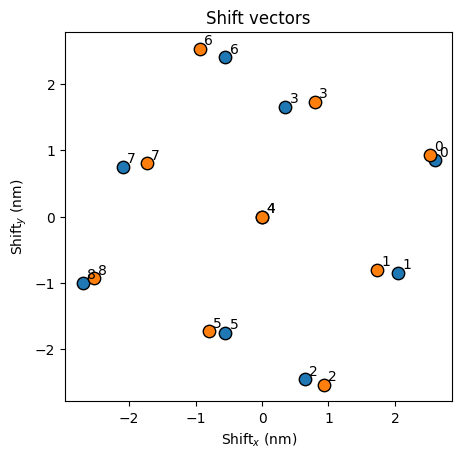

In [27]:
fig, ax = tool.PlotShiftVectors(shift_cell_crop)
tool.PlotShiftVectors(shift_sim_rot, fig = fig, ax = ax)
#something